In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Multivariate Gaussian Example

### per hand

## Closed-form posterior
For a 2-dimensional Gaussian prior with mean $\mu_0$ and covariance $\Sigma_0$ and data with mean $\bar{x}$ and covariance $\Sigma$ (generated by sampling from a 2-dimensional Gaussian, whose variance we assume to be known), the posterior parameters can be derived in closed form (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf):

$$ \Sigma_N = (\Sigma_0^{-1} + N \Sigma^{-1})^{-1}$$
$$ \mu_N = \Sigma_N (N \Sigma^{-1} \bar{x} + \Sigma_0^{-1} \mu_0) $$

In [2]:
# data parameters
mu = np.array([5.0, 7.0])
sigma = np.array([[2,0.5],[0.5,1]])
N = 10

# generate some data
x = np.random.multivariate_normal(mu, sigma, N)

In [3]:
# prior parameters
def prior_mu():
    mu0 = np.array([4.0, 4.0])
    sigma0 = np.array([[1,-0.5],[-0.5,0.7]])
    return np.random.multivariate_normal(mu0, sigma0)

def simulator(mu):
    sigma = np.array([[2,0.5],[0.5,1]])
    return np.random.multivariate_normal(mu, sigma, 10)

simulator(prior_mu())


array([[ 6.3847334 ,  3.8198565 ],
       [ 4.35792387,  4.78970553],
       [ 5.94824458,  4.12308716],
       [ 7.82367213,  6.38688062],
       [ 8.65737592,  4.50960552],
       [ 4.8444503 ,  3.48911755],
       [ 4.95336695,  5.04039947],
       [ 3.71615969,  5.38312146],
       [ 5.23361848,  3.28407771],
       [ 7.04700755,  4.95590179]])

In [7]:
# distance measure between sufficient statistics of two data sets
def mean(x):
    return np.mean(x, 0)


def cov(x):
    return np.cov(x.T)

def bhatt(mu1, sigma1, mu2, sigma2):
    # compute sufficient statistics (mean and covariance)
    sigma = 0.5 * (sigma1 + sigma2)
    da = 0.125 * (mu1 - mu2).T @ np.linalg.inv(sigma) @ (mu1 - mu2)
    db = 0.5 * np.log(np.linalg.det(sigma) / np.sqrt(np.linalg.det(sigma1) * np.linalg.det(sigma2)))
    return da + db

In [8]:
rej_samp = pyabc.RejectionSampler(
    priors=prior_mu,
    simulator=simulator,
    summaries=[mean, cov],
    discrepancy=bhatt,
    observation=x
)

In [9]:
rej_samp.sample(threshold=0.2, nr_samples=20)

Rejection sampler started with threshold: 0.2 and number of samples: 20
Samples:     20 - Threshold: 0.20 - Iterations:       2838 - Time:     1.80 s


<IPython.core.display.Javascript object>


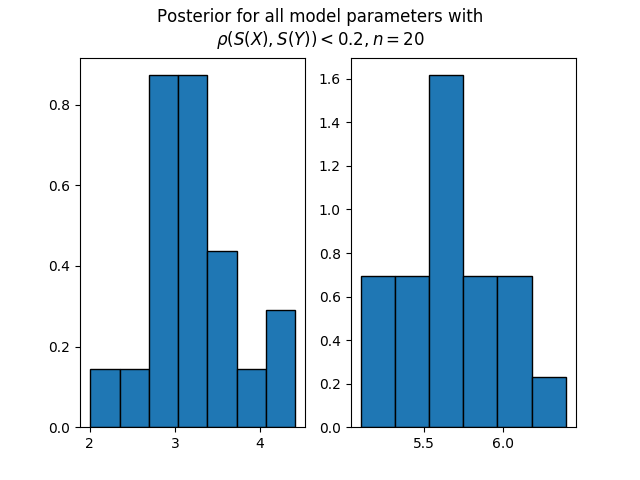

In [10]:
rej_samp.plot_marginals()